In [25]:
%pip install yfinance

In [54]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [55]:
tata = yf.download("TATASTEEL.NS", start="2023-11-02")
tata

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-02,114.599998,118.550003,114.599998,118.099998,118.099998,72538804
2023-11-03,118.199997,118.599998,117.099998,117.300003,117.300003,31747230


Define Tickers and Time Range

In [56]:
# tickers = ['SPY','BND','GLD','QQQ','VTI']
tickers = ['TATASTEEL.NS',"DALBHARAT.NS","MANINDS.NS","BIRLAMONEY.NS","SBILIFE.NS"]
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)
tickers

['TATASTEEL.NS', 'DALBHARAT.NS', 'MANINDS.NS', 'BIRLAMONEY.NS', 'SBILIFE.NS']

Download Adjusted Close Prices

In [57]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


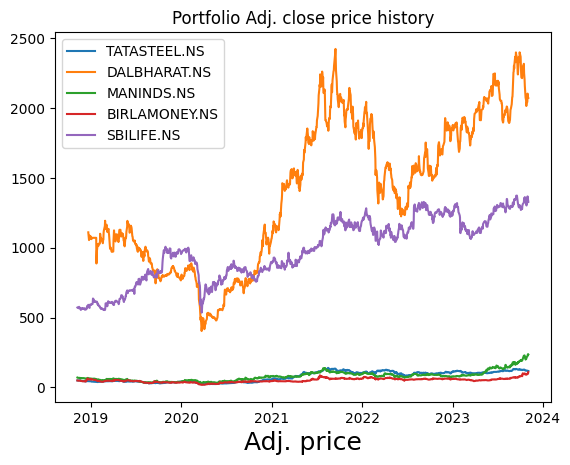

In [72]:
title= 'Portfolio Adj. close price history'
df = adj_close_df

for c in df.columns.values:
    plt.plot(df[c], label=c)

plt.title(title)
plt.xlabel("Date", fontsize=18)
plt.xlabel("Adj. price", fontsize=18)
plt.legend(df.columns.values, loc='upper left')
plt.show()


 calculate the lognormal returns for each asset and drop any missing values

In [59]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

Drop missing values

In [60]:
log_returns = log_returns.dropna()

calculate covariance matrix   (252 because of 252 trading days)

In [61]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

               TATASTEEL.NS  DALBHARAT.NS  MANINDS.NS  BIRLAMONEY.NS  \
TATASTEEL.NS       0.156154      0.049748    0.065131       0.062411   
DALBHARAT.NS       0.049748      0.149663    0.053070       0.056461   
MANINDS.NS         0.065131      0.053070    0.280796       0.082933   
BIRLAMONEY.NS      0.062411      0.056461    0.082933       0.255828   
SBILIFE.NS         0.036311      0.033120    0.033494       0.034831   

               SBILIFE.NS  
TATASTEEL.NS     0.036311  
DALBHARAT.NS     0.033120  
MANINDS.NS       0.033494  
BIRLAMONEY.NS    0.034831  
SBILIFE.NS       0.083637  


Performance matrix

In [62]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Calculate the expected return

In [63]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

risk-free rate

In [64]:
risk_free_rate = 0.07325

Sharp Ratio

In [65]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

negative sharpe raatio

In [66]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

set constraints and bounds

In [67]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]

set initial weights


In [68]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

optimize the weights to maximize the sharpe ratio

In [69]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

Analyze the Optimal Portfolio

In [70]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
TATASTEEL.NS: 0.2934
DALBHARAT.NS: 0.0000
MANINDS.NS: 0.3066
BIRLAMONEY.NS: 0.0000
SBILIFE.NS: 0.4000
Expected Annual Return: 0.2097
Expected Volatility: 0.2858
Sharpe Ratio: 0.4773


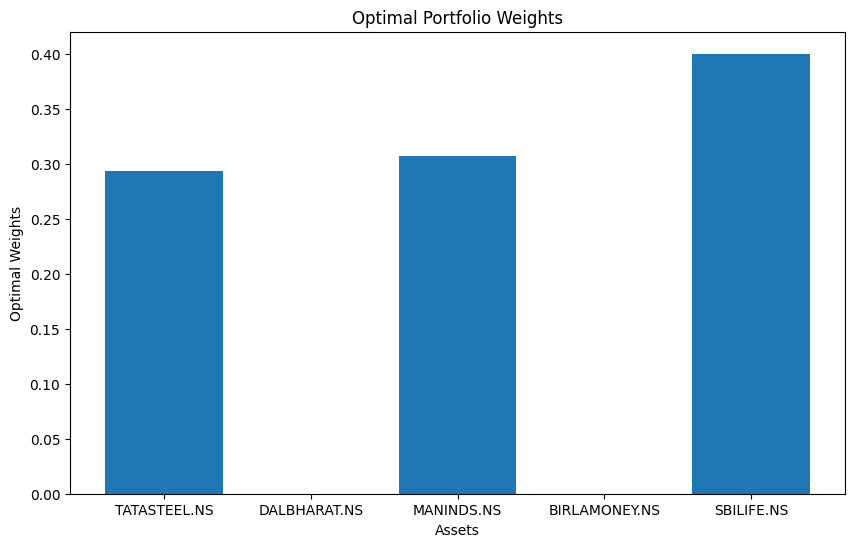

In [71]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()